In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


In [ ]:
import random
import pandas as pd


def load_data(path, nrows=None):
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data

# 경로 : load_data(path + '/불러올파일명.csv', nrows=1000)
train_data = load_data(path+'/train.csv', nrows=1000)
test_data = load_data(path+'/validation_matched.csv', nrows=1000)

print(f'train: {train_data[0]}')
print(f'test: {test_data[2]}')

train: {'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.', 'hypothesis': 'Product and geography are what make cream skimming work. ', 'label': 1}
test: {'premise': "uh i don't know i i have mixed emotions about him uh sometimes i like him but at the same times i love to see somebody beat him", 'hypothesis': 'I like him for the most part, but would still enjoy seeing someone beat him.', 'label': 0}


In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses

In [ ]:
import torch
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [ ]:
# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    texts, labels = [], []
    for row in batch:
        if row['label'] == -1:
            continue  # label 없는 샘플은 제거
        labels.append(row['label'])
        texts.append(f"{row['premise']} </s></s> {row['hypothesis']}")

    encodings = tokenizer(texts, padding=True)
    input_ids = torch.LongTensor(encodings['input_ids'])
    labels = torch.LongTensor(labels)
    return input_ids, labels

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
data_iter = iter(train_loader)
inputs, labels = next(data_iter)
print("입력 shape:", inputs.shape)
print("라벨 shape:", labels.shape)
print(f'{inputs[2]}')
print("예시 라벨:", labels[:10])
index = 3
print(f'test data: {test_data[index]}')
test_date_iter = iter(test_loader)
inputs, labels = next(test_date_iter)
print("입력 shape:", inputs.shape)
print("라벨 shape:", labels.shape)
print(f'{inputs[index]}')
print(f'{labels[index]}')
print(labels)
# 1026, 1013, 1055, 1028 > </s>
# 왜 shape이 train은 82, test는 122인가??

입력 shape: torch.Size([32, 88])
라벨 shape: torch.Size([32])
tensor([ 101, 2054, 2055, 2033, 1029, 1026, 1013, 1055, 1028, 1026, 1013, 1055,
        1028, 2033, 2205, 1029,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
예시 라벨: tensor([0, 0, 0, 2, 0, 0, 2, 2, 2, 2])
test data: {'premise': "yeah i i think my favorite restaurant is always been the one closest  you know the closest as long as it's it meets the minimum criteria you know of good food", 'hypothesis': 'My favorite restaurants are always at least a hundred miles away from my house. ', 'label': 2}
입력 shape

In [ ]:
#DistilBERT 모델 불러오기
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
        # [CLS] 토큰 분류기 정의
        self.classifier = nn.Linear(768, 3)

    def forward(self, x):
        # encoder에 input_ids 전달
        x = self.encoder(x)['last_hidden_state']
        # [CLS] 토큰 위치 벡터를 classification head에 전달
        # 모든 행에서 첫 번째 열에 해당하는 값들을 가져와서 1차원 배열(또는 텐서)로 반환
        x = self.classifier(x[:, 0])

        return x  # 0 or 1 or 2 label 출력

model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [ ]:
def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # label 출력
        #print(f'preds: {preds}')
        #
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]  # 총 샘플 수 누적(batch_size: 32)
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    print(f'총 샘플 수: {cnt}')
    print(f'정답 수: {acc}')

    return acc / cnt  # 정확도 반환

훈련 전 테스트

In [ ]:
pre_train_accs = []
pre_test_accs = []
pre_n_epochs = 10
model = model.to('cuda')  # 모델을 GPU로 이동
for epoch in range(pre_n_epochs):
  with torch.no_grad():
      model.eval()  # 평가 모드로 전환 (계산 비활성화)
      pre_train_accs.append(accuracy(model, train_loader))
      pre_test_accs.append(accuracy(model, test_loader))

총 샘플 수: 1000
정답 수: 339
총 샘플 수: 1000
정답 수: 336
총 샘플 수: 1000
정답 수: 362
총 샘플 수: 1000
정답 수: 336
총 샘플 수: 1000
정답 수: 359
총 샘플 수: 1000
정답 수: 336
총 샘플 수: 1000
정답 수: 335
총 샘플 수: 1000
정답 수: 336
총 샘플 수: 1000
정답 수: 332
총 샘플 수: 1000
정답 수: 336
총 샘플 수: 1000
정답 수: 314
총 샘플 수: 1000
정답 수: 336
총 샘플 수: 1000
정답 수: 348
총 샘플 수: 1000
정답 수: 336
총 샘플 수: 1000
정답 수: 334
총 샘플 수: 1000
정답 수: 336
총 샘플 수: 1000
정답 수: 347
총 샘플 수: 1000
정답 수: 336
총 샘플 수: 1000
정답 수: 347
총 샘플 수: 1000
정답 수: 336


In [ ]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# 학습 설정
lr = 0.001
n_epochs = 20
# model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()  # Classify 분류용 손실 함수

optimizer = Adam(model.parameters(), lr=lr)
# n_epochs = 5

train_accs = []
test_accs = []

# 학습 루프
for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # 학습 모드 설정

    for data in train_loader:
        model.zero_grad()  # 이전 gradient 초기화

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)

        loss = loss_fn(preds, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        total_loss += loss.item()  # loss 누적

    with torch.no_grad():
      model.eval()  # 평가 모드로 전환 (계산 비활성화)
      train_accs.append(accuracy(model, train_loader))
      test_accs.append(accuracy(model, test_loader))

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

총 샘플 수: 1000
정답 수: 406
총 샘플 수: 1000
정답 수: 356
Epoch   0 | Train Loss: 35.18060898780823
총 샘플 수: 1000
정답 수: 446
총 샘플 수: 1000
정답 수: 370
Epoch   1 | Train Loss: 34.793564796447754
총 샘플 수: 1000
정답 수: 404
총 샘플 수: 1000
정답 수: 357
Epoch   2 | Train Loss: 34.16876566410065
총 샘플 수: 1000
정답 수: 451
총 샘플 수: 1000
정답 수: 365
Epoch   3 | Train Loss: 34.117994606494904
총 샘플 수: 1000
정답 수: 467
총 샘플 수: 1000
정답 수: 357
Epoch   4 | Train Loss: 33.71324038505554
총 샘플 수: 1000
정답 수: 483
총 샘플 수: 1000
정답 수: 363
Epoch   5 | Train Loss: 33.69132912158966
총 샘플 수: 1000
정답 수: 479
총 샘플 수: 1000
정답 수: 364
Epoch   6 | Train Loss: 33.21922808885574
총 샘플 수: 1000
정답 수: 484
총 샘플 수: 1000
정답 수: 371
Epoch   7 | Train Loss: 33.400786340236664
총 샘플 수: 1000
정답 수: 457
총 샘플 수: 1000
정답 수: 362
Epoch   8 | Train Loss: 32.96481496095657
총 샘플 수: 1000
정답 수: 472
총 샘플 수: 1000
정답 수: 367
Epoch   9 | Train Loss: 32.799770414829254
총 샘플 수: 1000
정답 수: 491
총 샘플 수: 1000
정답 수: 370
Epoch  10 | Train Loss: 32.63976812362671
총 샘플 수: 1000
정답 수: 495
총 샘플 

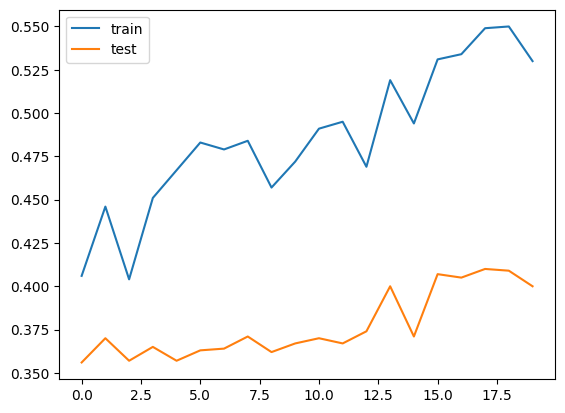

In [ ]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_accs, test_accs, 'train', 'test')

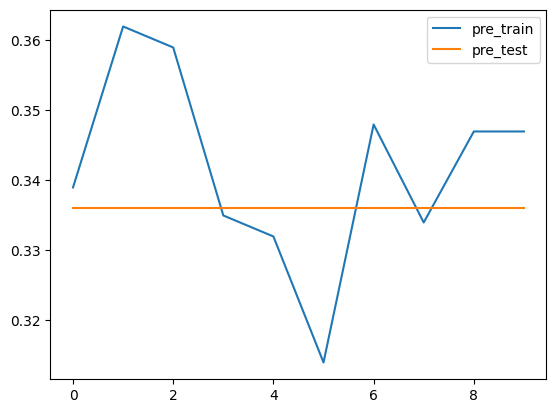

In [ ]:
plot_acc(pre_train_accs, pre_test_accs, 'pre_train', 'pre_test')

입/출력 테스트

In [ ]:
def preprocess_input(premise, hypothesis):
  text = f"{premise} </s></s> {hypothesis}"
  encodings = tokenizer(text, return_tensors="pt")
  input_ids = encodings['input_ids']
  return input_ids

def predict(model, input_ids):
  model.eval()  # 평가 모드로 전환
  with torch.no_grad():
    input_ids = input_ids.to('cuda')  # 입력을 GPU로 이동
    preds = model(input_ids)  # 모델 예측
    predicted_label = torch.argmax(preds, dim=-1).item()  # 예측 레이블 (0, 1, 2)
  return predicted_label

def interpret_prediction(prediction):
  label_mapping = {
    0: "Entailment",
    1: "Neutral",
    2: "Contradiction"
  }
  return label_mapping[prediction]

def run_inference(premise, hypothesis):
  input_ids = preprocess_input(premise, hypothesis)
  prediction = predict(model, input_ids)
  result = interpret_prediction(prediction)
  print(f"Premise: {premise}")
  print(f"Hypothesis: {hypothesis}")
  print(f"Prediction: {result}")

In [ ]:
import random

# test_data에서 10개 샘플 추출
num_samples = 20
selected_samples = random.sample(test_data, num_samples)

for sample in selected_samples:
  premise = sample['premise']
  hypothesis = sample['hypothesis']
  run_inference(premise, hypothesis)
  print("-" * 20) # 구분선 출력

Premise: One or two, replied Tommy modestly, and plunged into his recital.
Hypothesis: Tommy stopped playing.
Prediction: Neutral
--------------------
Premise: Yes, you've done very well, young man.
Hypothesis: No, you have not done very well.
Prediction: Contradiction
--------------------
Premise: For big Raj-buffs, the supreme example of Indo-Gothic style is the Victoria Terminus, affectionately abbreviated to VT nowadays, once the railway station that launched adventures inland, now handling mostly suburban traffic.
Hypothesis: The Victoria Terminus is still the main departure point for travelers heading deeper into the country.
Prediction: Contradiction
--------------------
Premise: You will find two principal  fino and olorose
Hypothesis: You won't find any fino or olorose.
Prediction: Entailment
--------------------
Premise: The vineyards hug the gentle slopes between the Vosges and the Rhine Valley along a single narrow 120-km (75-mile) strip that stretches from Marlenheim, just